In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random
import math
import openpyxl

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 定义不同情况的参数
cases = [
    {'零配件1次品率': 0.1, '零配件2次品率': 0.1, '成品次品率': 0.1, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 6, '拆解费用': 5},
    {'零配件1次品率': 0.2, '零配件2次品率': 0.2, '成品次品率': 0.2, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 6, '拆解费用': 5},
    {'零配件1次品率': 0.1, '零配件2次品率': 0.1, '成品次品率': 0.1, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 30, '拆解费用': 5},
    {'零配件1次品率': 0.2, '零配件2次品率': 0.2, '成品次品率': 0.2, '零配件1检测成本': 1, '零配件2检测成本': 1,
     '成品检测成本': 2, '装配成本': 6, '市场售价': 56, '调换损失': 30, '拆解费用': 5},
    {'零配件1次品率': 0.1, '零配件2次品率': 0.2, '成品次品率': 0.1, '零配件1检测成本': 8, '零配件2检测成本': 1,
     '成品检测成本': 2, '装配成本': 6, '市场售价': 56, '调换损失': 10, '拆解费用': 5},
    {'零配件1次品率': 0.05, '零配件2次品率': 0.05, '成品次品率': 0.05, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 10, '拆解费用': 40}
]

# 计算总成本和成品次品率的函数
def calc_total_cost(case, detect_parts1=True, detect_parts2=True, detect_final=True, dismantle=True):
    n_parts1 = 100  # 零配件1的数量
    n_parts2 = 100  # 零配件2的数量
    cost_parts1 = n_parts1 * case['零配件1检测成本'] if detect_parts1 else 0  # 零配件1的检测成本
    cost_parts2 = n_parts2 * case['零配件2检测成本'] if detect_parts2 else 0  # 零配件2的检测成本

    loss_parts1 = (n_parts1 * case['零配件1次品率']) * (case['装配成本']) if not detect_parts1 else 0  # 零配件1的次品损失
    loss_parts2 = (n_parts2 * case['零配件2次品率']) * (case['装配成本']) if not detect_parts2 else 0  # 零配件2的次品损失

    n_final_products = 100  # 成品数量
    cost_final = n_final_products * case['成品检测成本'] if detect_final else 0  # 成品的检测成本
    loss_final = (n_final_products * case['成品次品率']) * case['调换损失'] if not detect_final else 0  # 成品的次品损失

    dismantle_cost = n_final_products * case['拆解费用'] if dismantle else 0  # 拆解费用
    dismantle_revenue = (n_final_products * case['成品次品率']) * case['市场售价'] if dismantle else 0  # 拆解收益

    total_cost = (cost_parts1 + cost_parts2 + loss_parts1 + loss_parts2 +
                  cost_final + loss_final + dismantle_cost - dismantle_revenue)  # 总成本

    defective_rate = case['成品次品率'] * (1 if detect_final else 0.5)  # 成品次品率

    return total_cost, defective_rate

# 适应度函数：计算策略的总成本的负值（因为我们希望最小化总成本）
def fitness_function(strategy, case):
    total_cost, _ = calc_total_cost(case, **strategy)
    return -total_cost

# 初始化策略
def initialize_strategy():
    return {
        "detect_parts1": random.choice([True, False]),
        "detect_parts2": random.choice([True, False]),
        "detect_final": random.choice([True, False]),
        "dismantle": random.choice([True, False])
    }

# 生成邻域解
def generate_neighbor(strategy):
    neighbor = strategy.copy()
    key = random.choice(list(neighbor.keys()))
    neighbor[key] = not neighbor[key]
    return neighbor

# 模拟退火算法主循环
def simulated_annealing(case, initial_temperature=1000, cooling_rate=0.95, stopping_temperature=0.1):
    current_strategy = initialize_strategy()
    current_fitness = fitness_function(current_strategy, case)
    best_strategy = current_strategy
    best_fitness = current_fitness
    temperature = initial_temperature

    while temperature > stopping_temperature:
        neighbor_strategy = generate_neighbor(current_strategy)
        neighbor_fitness = fitness_function(neighbor_strategy, case)

        if neighbor_fitness > current_fitness or random.random() < math.exp((neighbor_fitness - current_fitness) / temperature):
            current_strategy = neighbor_strategy
            current_fitness = neighbor_fitness

        if current_fitness > best_fitness:
            best_strategy = current_strategy
            best_fitness = current_fitness

        temperature *= cooling_rate

    return best_strategy

# 运行模拟退火算法并生成结果
def run_simulated_annealing(case, num_runs=10):
    best_strategies = []
    best_costs = []
    best_defective_rates = []

    for _ in range(num_runs):
        best_strategy = simulated_annealing(case)
        best_strategies.append(best_strategy)
        total_cost, defective_rate = calc_total_cost(case, **best_strategy)
        best_costs.append(total_cost)
        best_defective_rates.append(defective_rate)

    return best_strategies, best_costs, best_defective_rates

# 运行交叉验证并生成结果
num_runs = 10
best_strategies_all = []
best_costs_all = []
best_defective_rates_all = []

for case in cases:
    best_strategies, best_costs, best_defective_rates = run_simulated_annealing(case, num_runs)
    best_strategies_all.append(best_strategies)
    best_costs_all.append(best_costs)
    best_defective_rates_all.append(best_defective_rates)

# 计算均值和标准差
mean_costs = np.mean(best_costs_all, axis=1)
std_costs = np.std(best_costs_all, axis=1)
mean_defective_rates = np.mean(best_defective_rates_all, axis=1)
std_defective_rates = np.std(best_defective_rates_all, axis=1)

# 输出结果到xlsx文件
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "B2策略"
ws.append(["策略编号", "策略描述", "总成本均值", "总成本标准差", "成品次品率均值", "成品次品率标准差"])
for i, strategies in enumerate(best_strategies_all):
    strategy_description = (
        f"检测零配件1: {'是' if strategies[0]['detect_parts1'] else '否'}, "
        f"检测零配件2: {'是' if strategies[0]['detect_parts2'] else '否'}, "
        f"检测成品: {'是' if strategies[0]['detect_final'] else '否'}, "
        f"拆解不合格成品: {'是' if strategies[0]['dismantle'] else '否'}"
    )
    ws.append([i + 1, strategy_description, mean_costs[i], std_costs[i], mean_defective_rates[i], std_defective_rates[i]])
wb.save('B2策略.xlsx')

# 可视化结果
plt.figure(figsize=(10, 6))
for i in range(len(cases)):
    plt.plot(range(1, num_runs + 1), best_costs_all[i], marker='o', label=f"情况 {i + 1} - 总成本")
plt.xlabel("运行次数")
plt.ylabel("总成本")
plt.title("不同情况下的总成本比较")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(cases)):
    plt.plot(range(1, num_runs + 1), best_defective_rates_all[i], marker='x', linestyle='--', label=f"情况 {i + 1} - 成品次品率")
plt.xlabel("运行次数")
plt.ylabel("成品次品率")
plt.title("不同情况下的成品次品率比较")
plt.legend()
plt.grid(True)
plt.show()

# 生成所有可能策略
strategies = []
for detect_parts1 in [True, False]:
    for detect_parts2 in [True, False]:
        for detect_final in [True, False]:
            for dismantle in [True, False]:
                strategies.append({
                    "detect_parts1": detect_parts1,
                    "detect_parts2": detect_parts2,
                    "detect_final": detect_final,
                    "dismantle": dismantle
                })

strategy_explanations = []
for i, strategy in enumerate(strategies):
    strategy_explanations.append(
        f"策略 {i + 1}: 检测零配件 1 {'是' if strategy['detect_parts1'] else '否'}，检测零配件 2 {'是' if strategy['detect_parts2'] else '否'}，"
        f"检测成品 {'是' if strategy['detect_final'] else '否'}，拆解不合格成品 {'是' if strategy['dismantle'] else '否'}"
    )

costs = []
defective_rates = []

for i, case in enumerate(cases):
    case_costs = []
    case_defective_rates = []
    for j, strategy in enumerate(strategies):
        total_cost, defective_rate = calc_total_cost(case, **strategy)
        case_costs.append(total_cost)
        case_defective_rates.append(defective_rate)
    costs.append(case_costs)
    defective_rates.append(case_defective_rates)

costs = np.array(costs)
defective_rates = np.array(defective_rates)

plt.figure(figsize=(10, 6))
for i in range(costs.shape[1]):
    plt.plot(range(1, costs.shape[0] + 1), costs[:, i], marker='o', label=f"策略 {i + 1} - 总成本")
plt.xlabel("情况")
plt.ylabel("总成本")
plt.title("不同情况和策略下的总成本比较")
plt.legend()
plt.grid(True)
plt.show()

最新B2(完美代码)

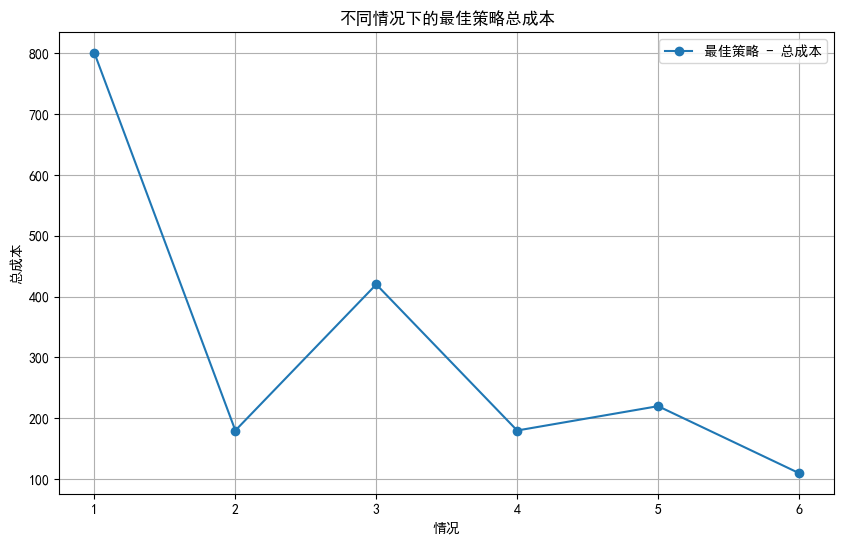

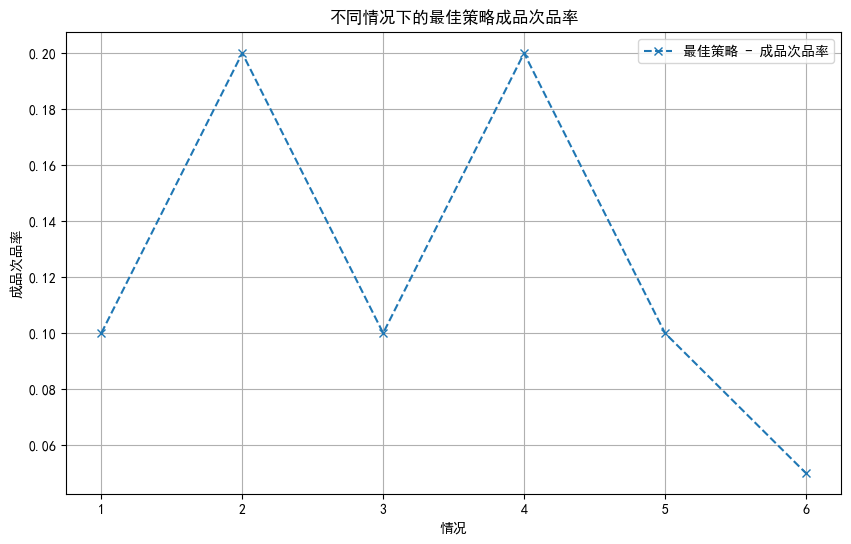

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random
import openpyxl

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# 定义不同情况的参数
cases = [
    {'零配件1次品率': 0.1, '零配件2次品率': 0.1, '成品次品率': 0.1, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 6, '拆解费用': 5},
    {'零配件1次品率': 0.2, '零配件2次品率': 0.2, '成品次品率': 0.2, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 6, '拆解费用': 5},
    {'零配件1次品率': 0.1, '零配件2次品率': 0.1, '成品次品率': 0.1, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 30, '拆解费用': 5},
    {'零配件1次品率': 0.2, '零配件2次品率': 0.2, '成品次品率': 0.2, '零配件1检测成本': 1, '零配件2检测成本': 1,
     '成品检测成本': 2, '装配成本': 6, '市场售价': 56, '调换损失': 30, '拆解费用': 5},
    {'零配件1次品率': 0.1, '零配件2次品率': 0.2, '成品次品率': 0.1, '零配件1检测成本': 8, '零配件2检测成本': 1,
     '成品检测成本': 2, '装配成本': 6, '市场售价': 56, '调换损失': 10, '拆解费用': 5},
    {'零配件1次品率': 0.05, '零配件2次品率': 0.05, '成品次品率': 0.05, '零配件1检测成本': 2, '零配件2检测成本': 3,
     '成品检测成本': 3, '装配成本': 6, '市场售价': 56, '调换损失': 10, '拆解费用': 5}
]

# 计算总成本和成品次品率的函数
def calc_total_cost(case, detect_parts1=True, detect_parts2=True, detect_final=True, dismantle=True):
    n_parts1 = 100  # 零配件1的数量
    n_parts2 = 100  # 零配件2的数量
    n_final_products = 100  # 成品数量

    # 零配件1和零配件2的检测成本
    cost_parts1 = n_parts1 * case['零配件1检测成本'] if detect_parts1 else 0
    cost_parts2 = n_parts2 * case['零配件2检测成本'] if detect_parts2 else 0

    # 零配件1和零配件2的次品损失，仅在未检测时计算
    loss_parts1 = (n_parts1 * case['零配件1次品率']) * case['装配成本'] if not detect_parts1 else 0
    loss_parts2 = (n_parts2 * case['零配件2次品率']) * case['装配成本'] if not detect_parts2 else 0

    # 成品的检测成本
    cost_final = n_final_products * case['成品检测成本'] if detect_final else 0

    # 成品的次品损失，仅在未检测时计算
    loss_final = (n_final_products * case['成品次品率']) * case['调换损失'] if not detect_final else 0

    # 拆解操作的费用和收益
    if dismantle:
        dismantle_cost = n_final_products * case['拆解费用']
        dismantle_revenue = (n_final_products * case['成品次品率']) * case['市场售价']
    else:
        dismantle_cost = 0
        dismantle_revenue = 0

    total_cost = (cost_parts1 + cost_parts2 + loss_parts1 + loss_parts2 +
                  cost_final + loss_final + dismantle_cost - dismantle_revenue)  # 总成本

    defective_rate = case['成品次品率']  # 固定成品次品率

    return total_cost, defective_rate

# 适应度函数：计算策略的总成本的负值（因为我们希望最小化总成本）
def fitness_function(strategy, case):
    total_cost, _ = calc_total_cost(case, **strategy)
    return -total_cost

# 初始化种群：生成初始策略组合
def initialize_population(population_size):
    return [{
        "detect_parts1": random.choice([True, False]),
        "detect_parts2": random.choice([True, False]),
        "detect_final": random.choice([True, False]),
        "dismantle": random.choice([True, False])
    } for _ in range(population_size)]

# 选择操作：选择适应度较高的个体进行繁殖
def selection(population, fitnesses, num_parents):
    parents = []
    for _ in range(num_parents):
        max_fitness_index = fitnesses.index(max(fitnesses))
        parents.append(population[max_fitness_index])
        fitnesses[max_fitness_index] = float('-inf')
    return parents

# 变异操作：引入新的基因
def mutation(strategy, mutation_rate):
    for key in strategy:
        if random.random() < mutation_rate:
            strategy[key] = not strategy[key]
    return strategy

# 遗传算法主循环
def genetic_algorithm(case, population_size=100, num_generations=100, mutation_rate=0.01):
    population = initialize_population(population_size)
    for _ in range(num_generations):
        fitnesses = [fitness_function(strategy, case) for strategy in population]
        parents = selection(population, fitnesses, population_size // 2)
        new_population = parents[:]
        while len(new_population) < population_size:
            parent = random.choice(parents)
            child = mutation(parent, mutation_rate)
            new_population.append(child)
        population = new_population
    fitnesses = [fitness_function(strategy, case) for strategy in population]
    best_strategy = population[fitnesses.index(max(fitnesses))]
    return best_strategy

# 生成策略描述和结果的函数
def generate_strategy_description(strategy):
    return (
        f"检测零配件1: {'是' if strategy['detect_parts1'] else '否'}, "
        f"检测零配件2: {'是' if strategy['detect_parts2'] else '否'}, "
        f"检测成品: {'是' if strategy['detect_final'] else '否'}, "
        f"拆解不合格成品: {'是' if strategy['dismantle'] else '否'}"
    )

# 输出结果到xlsx文件
def output_to_excel(filename, best_strategies, best_costs, best_defective_rates):
    wb = openpyxl.Workbook()
    ws = wb.active
    ws.title = "策略结果"
    ws.append(["策略编号", "策略描述", "总成本", "成品次品率"])
    for i, strategy in enumerate(best_strategies):
        strategy_description = generate_strategy_description(strategy)
        ws.append([i + 1, strategy_description, best_costs[i], best_defective_rates[i]])
    wb.save(filename)

# 可视化结果函数
def plot_results(cases, best_costs, best_defective_rates):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cases) + 1), best_costs, marker='o', label="最佳策略 - 总成本")
    plt.xlabel("情况")
    plt.ylabel("总成本")
    plt.title("不同情况下的最佳策略总成本")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cases) + 1), best_defective_rates, marker='x', linestyle='--', label="最佳策略 - 成品次品率")
    plt.xlabel("情况")
    plt.ylabel("成品次品率")
    plt.title("不同情况下的最佳策略成品次品率")
    plt.legend()
    plt.grid(True)
    plt.show()

# 执行优化和输出
def run_optimization_and_output(cases):
    best_strategies = [genetic_algorithm(case) for case in cases]
    best_costs = []
    best_defective_rates = []
    for i, case in enumerate(cases):
        total_cost, defective_rate = calc_total_cost(case, **best_strategies[i])
        best_costs.append(total_cost)
        best_defective_rates.append(defective_rate)

    output_to_excel('策略结果.xlsx', best_strategies, best_costs, best_defective_rates)
    plot_results(cases, best_costs, best_defective_rates)

# 运行优化并生成结果
run_optimization_and_output(cases)
